<a href="https://colab.research.google.com/github/Seyoan/INM363_resit/blob/main/PlantVillage_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Leaf Dataset PlantVillage

## Transfer Learning models (VGG19, GoogLeNet, ResNet50)

Inspiration taken from: https://www.kaggle.com/code/sakthimurugavel/potato-leaf-disease-classifier-review-ii-final/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the required dependencies

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.utils import plot_model

### Define the constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 20

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/PlantVillage"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                              shuffle = True, 
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                              batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names # 0 = early blight, 1 = late blight, 2 = healthy

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
def DatasetSize(path):
    number_of_images = {} #Dictionary
    for folder in os.listdir(path):
        number_of_images[folder] = len(os.listdir(os.path.join(path, folder)))
    return number_of_images

data_set = DatasetSize(path)
print(data_set)

{'Potato___healthy': 152, 'Potato___Early_blight': 1000, 'Potato___Late_blight': 1000}


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 1 0 1 0 1 0 1 0 0 0 1 0 0 2 0 0 1 1 1 1 1 0 0 1 0 2 2 0 0 0 1]


### Visualise the images

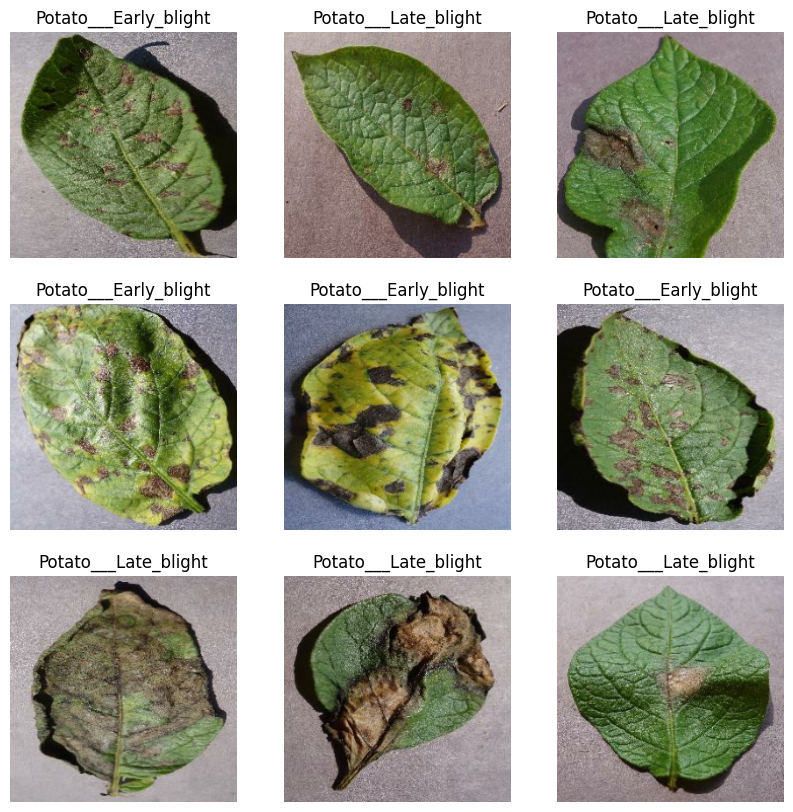

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Split the dataset

In [ ]:
# Use split folders
#splitfolders --ratio .8 .1 .1 -- 

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio(path, output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2152 files [00:15, 142.54 files/s]


### Data Preprocessing and Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/output/train",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")

Found 1721 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
# Validation 

validation_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

validation_generator = validation_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/output/val",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")


Found 215 images belonging to 3 classes.


In [ ]:
# Test

test_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/output/test",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")


Found 216 images belonging to 3 classes.


### VGG19

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(VGG19(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
vgg19_with_aug_model = create_model()
vgg19_with_aug_model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 77

### Compiling the model and determining the accuracy

In [ ]:
vgg19_with_aug_model.compile(
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
vgg19_with_aug_history = vgg19_with_aug_model.fit(
    train_generator,
    steps_per_epoch=54,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=7,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
54/54 [==============================] - 443s 8s/step - loss: 0.4212 - accuracy: 0.8367 - val_loss: 0.1704 - val_accuracy: 0.9395
Epoch 2/20
54/54 [==============================] - 25s 455ms/step - loss: 0.4070 - accuracy: 0.8664 - val_loss: 0.1985 - val_accuracy: 0.9023
Epoch 3/20
54/54 [==============================] - 25s 455ms/step - loss: 0.1314 - accuracy: 0.9535 - val_loss: 0.1201 - val_accuracy: 0.9442
Epoch 4/20
54/54 [==============================] - 25s 453ms/step - loss: 0.1130 - accuracy: 0.9692 - val_loss: 0.0777 - val_accuracy: 0.9767
Epoch 5/20
54/54 [==============================] - 25s 457ms/step - loss: 0.0671 - accuracy: 0.9791 - val_loss: 0.1498 - val_accuracy: 0.9535
Epoch 6/20
54/54 [==============================] - 25s 455ms/step - loss: 0.0789 - accuracy: 0.9739 - val_loss: 0.0681 - val_accuracy: 0.9767
Epoch 7/20
54/54 [==============================] - 25s 455ms/step - loss: 0.0514 - accuracy: 0.9791 - val_loss: 0.0623 - val_accuracy: 0.9767
E

### Producing the test accuracy and test loss

In [ ]:
vgg19_with_aug_scores = vgg19_with_aug_model.evaluate(test_generator)
vgg19_with_aug_test_acc = vgg19_with_aug_scores[1]*100
vgg19_with_aug_test_loss = vgg19_with_aug_scores[0]
print("Test Loss: ", vgg19_with_aug_test_loss) 
print("Test Accuracy: ", vgg19_with_aug_test_acc) 

7/7 [==============================] - 64s 11s/step - loss: 0.0498 - accuracy: 0.9815
Test Loss:  0.04982779547572136
Test Accuracy:  98.14814925193787


### VGG19 plot for accuracy vs loss 

In [ ]:
vgg19_with_aug_history

In [ ]:
vgg19_with_aug_acc = vgg19_with_aug_history.history['accuracy']
vgg19_with_aug_val_acc = vgg19_with_aug_history.history['val_accuracy']

vgg19_with_aug_loss = vgg19_with_aug_history.history['loss']
vgg19_with_aug_val_loss = vgg19_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

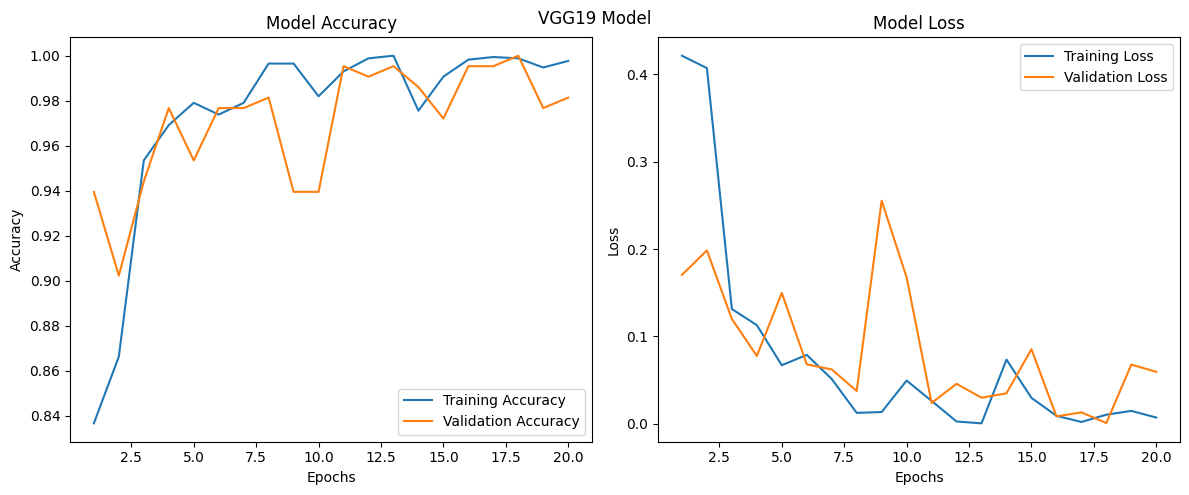

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, vgg19_with_aug_acc, label='Training Accuracy')
plt.plot(n, vgg19_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, vgg19_with_aug_loss, label='Training Loss')
plt.plot(n, vgg19_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('VGG19 Model')
plt.savefig("plot_vgg19.png")
plt.show()

### Prediction of images using VGG19

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


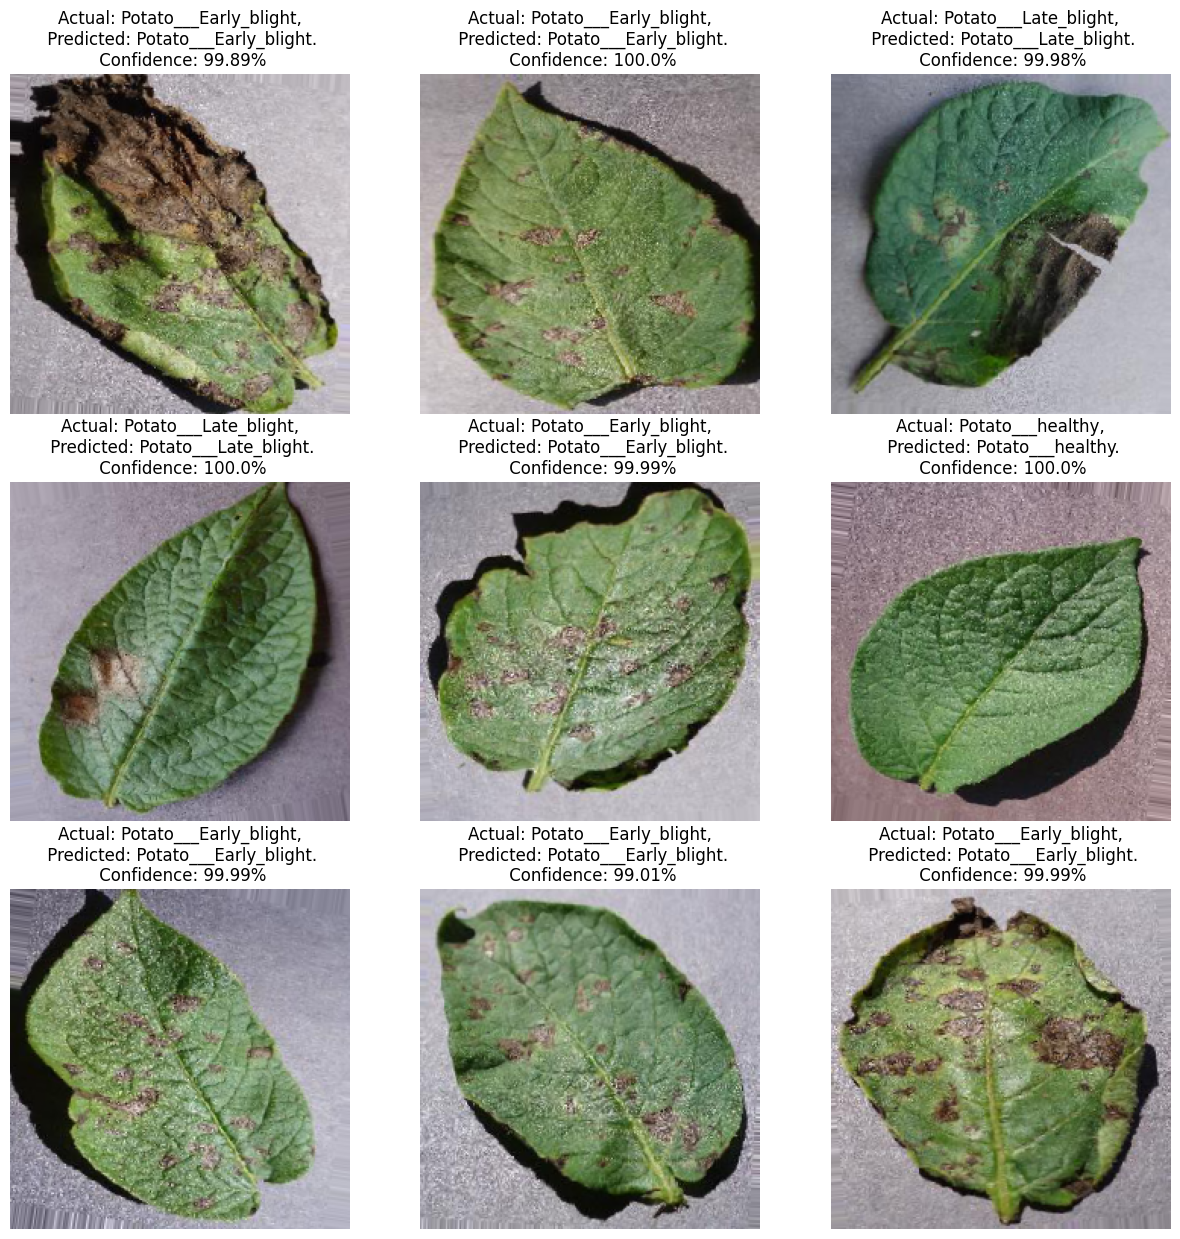

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(vgg19_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("VGG19_prediction images")
plt.show()

### GoogLeNet (InceptionV3)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(InceptionV3(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
inceptionv3_with_aug_model = create_model()
inceptionv3_with_aug_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 

### Compiling the model and determining the accuracy

In [ ]:
inceptionv3_with_aug_model.compile(
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
inceptionv3_with_aug_history = inceptionv3_with_aug_model.fit(train_generator,
                                                   steps_per_epoch=54,
                                                   batch_size=32,
                                                   validation_data=validation_generator,
                                                    validation_steps = 7,
                                                    verbose=1,
                                                    epochs=EPOCHS)

Epoch 1/20
54/54 [==============================] - 65s 512ms/step - loss: 0.2415 - accuracy: 0.9030 - val_loss: 0.2436 - val_accuracy: 0.9209
Epoch 2/20
54/54 [==============================] - 25s 457ms/step - loss: 0.0609 - accuracy: 0.9797 - val_loss: 0.0356 - val_accuracy: 0.9907
Epoch 3/20
54/54 [==============================] - 25s 454ms/step - loss: 0.0207 - accuracy: 0.9948 - val_loss: 0.0177 - val_accuracy: 0.9907
Epoch 4/20
54/54 [==============================] - 24s 449ms/step - loss: 0.0221 - accuracy: 0.9959 - val_loss: 0.0453 - val_accuracy: 0.9907
Epoch 5/20
54/54 [==============================] - 24s 447ms/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/20
54/54 [==============================] - 24s 449ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0107 - val_accuracy: 0.9953
Epoch 7/20
54/54 [==============================] - 24s 448ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.0062 - val_accuracy: 0.9953

### Producing the test accuracy and test loss

In [ ]:
inceptionv3_with_aug_scores = inceptionv3_with_aug_model.evaluate(test_generator)
inceptionv3_with_aug_test_acc = inceptionv3_with_aug_scores[1]*100
inceptionv3_with_aug_test_loss = inceptionv3_with_aug_scores[0]
print("Test Loss: ", inceptionv3_with_aug_test_loss)
print("Test Accuracy: ", inceptionv3_with_aug_test_acc) 

7/7 [==============================] - 3s 472ms/step - loss: 0.0367 - accuracy: 0.9954
Test Loss:  0.0367109440267086
Test Accuracy:  99.53703880310059


### InceptionV3 plot for accuracy vs loss 

In [ ]:
inceptionv3_with_aug_history

In [ ]:
inceptionv3_with_aug_acc = inceptionv3_with_aug_history.history['accuracy']
inceptionv3_with_aug_val_acc = inceptionv3_with_aug_history.history['val_accuracy']

inceptionv3_with_aug_loss = inceptionv3_with_aug_history.history['loss']
inceptionv3_with_aug_val_loss = inceptionv3_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

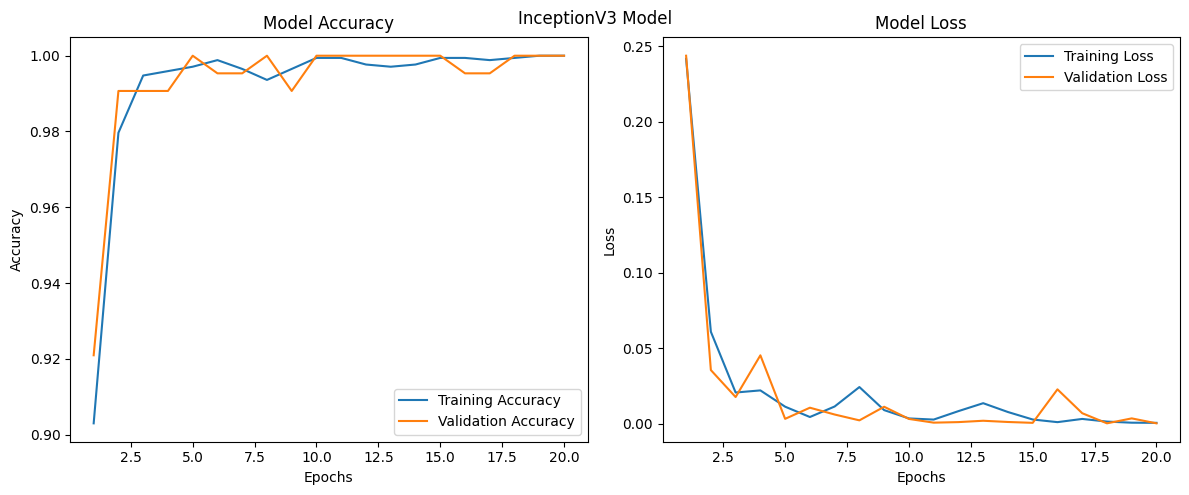

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, inceptionv3_with_aug_acc, label='Training Accuracy')
plt.plot(n, inceptionv3_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, inceptionv3_with_aug_loss, label='Training Loss')
plt.plot(n, inceptionv3_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('InceptionV3 Model')
plt.savefig("plot_inceptionv3.png")
plt.show()

### Prediction of images using InceptionV3

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


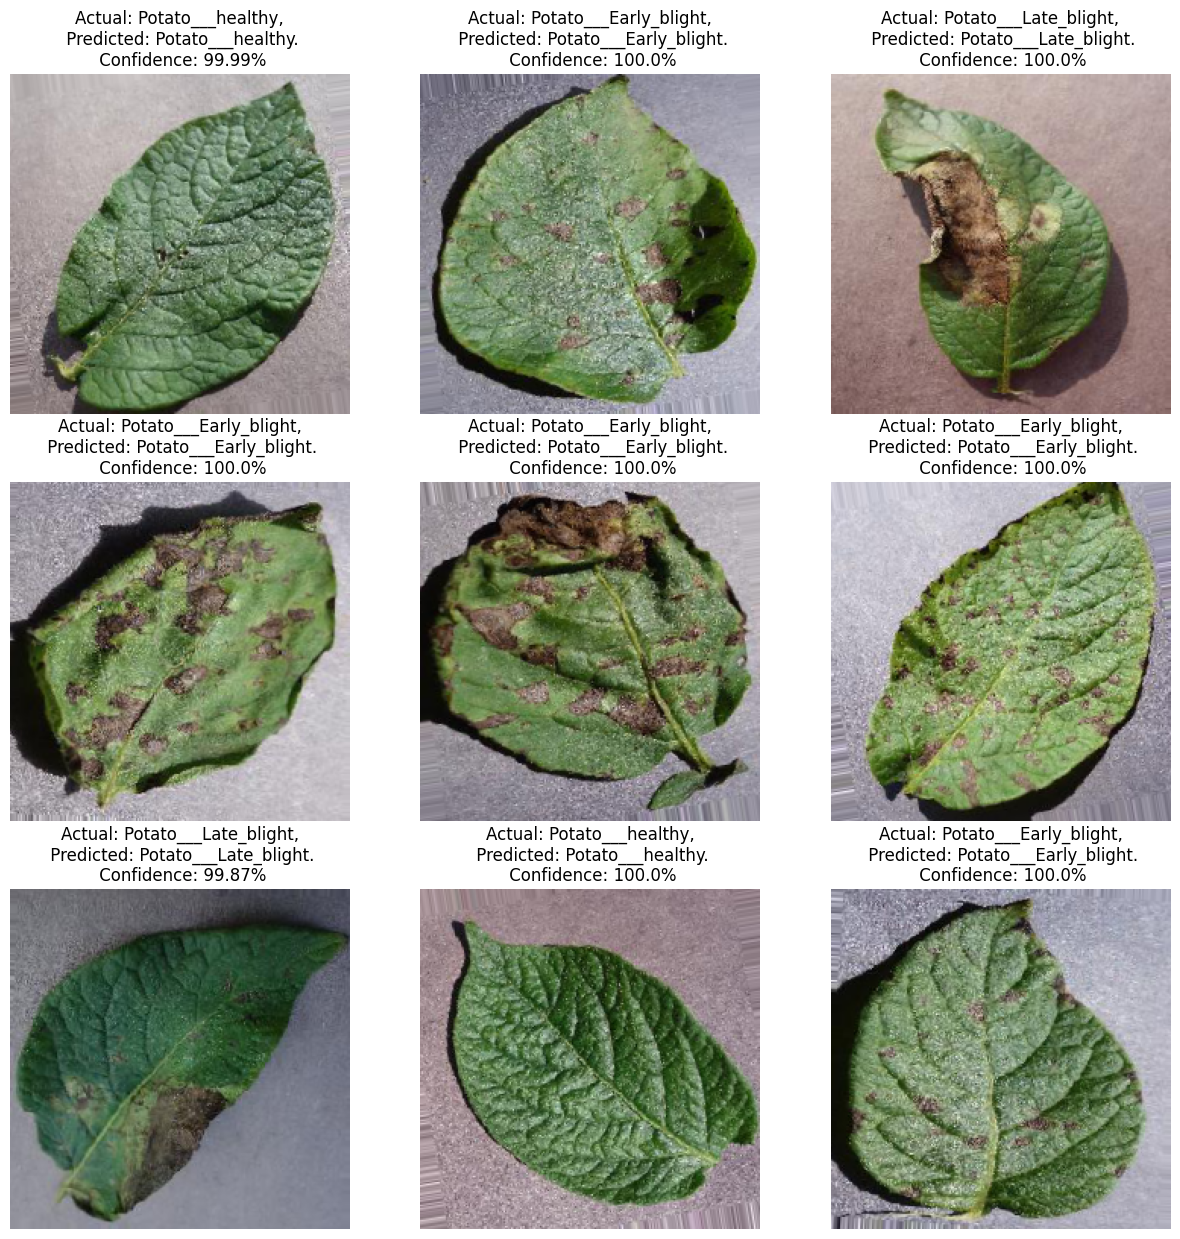

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(inceptionv3_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("InceptionV3_prediction images")

### ResNet50

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(ResNet50V2(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
resnet50_with_aug_model = create_model()
resnet50_with_aug_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 

### Compiling the model and determining the accuracy

In [ ]:
resnet50_with_aug_model.compile(
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
resnet50_with_aug_history = resnet50_with_aug_model.fit(train_generator,
                                                   steps_per_epoch=54,
                                                   batch_size=32,
                                                   validation_data=validation_generator,
                                                    validation_steps = 7,
                                                    verbose=1,
                                                    epochs=EPOCHS)

Epoch 1/20
54/54 [==============================] - 58s 487ms/step - loss: 0.2174 - accuracy: 0.9227 - val_loss: 0.1925 - val_accuracy: 0.9256
Epoch 2/20
54/54 [==============================] - 24s 447ms/step - loss: 0.0387 - accuracy: 0.9872 - val_loss: 0.0306 - val_accuracy: 0.9860
Epoch 3/20
54/54 [==============================] - 24s 449ms/step - loss: 0.0196 - accuracy: 0.9959 - val_loss: 0.0422 - val_accuracy: 0.9860
Epoch 4/20
54/54 [==============================] - 24s 447ms/step - loss: 0.0237 - accuracy: 0.9913 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 5/20
54/54 [==============================] - 24s 449ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0103 - val_accuracy: 0.9953
Epoch 6/20
54/54 [==============================] - 24s 446ms/step - loss: 0.0130 - accuracy: 0.9948 - val_loss: 0.0174 - val_accuracy: 0.9907
Epoch 7/20
54/54 [==============================] - 24s 450ms/step - loss: 0.0125 - accuracy: 0.9965 - val_loss: 0.0085 - val_accuracy: 0.9953

### Producing the test accuracy and test loss

In [ ]:
resnet50_with_aug_scores = resnet50_with_aug_model.evaluate(test_generator)
resnet50_with_aug_test_acc = resnet50_with_aug_scores[1]*100
resnet50_with_aug_test_loss = resnet50_with_aug_scores[0]
print("Test Loss: ", resnet50_with_aug_test_loss) 
print("Test Accuracy: ", resnet50_with_aug_test_acc) 

7/7 [==============================] - 3s 432ms/step - loss: 0.0080 - accuracy: 0.9954
Test Loss:  0.007989414036273956
Test Accuracy:  99.53703880310059


### ResNet50 plot for accuracy vs loss

In [ ]:
resnet50_with_aug_history

In [ ]:
resnet50_with_aug_acc = resnet50_with_aug_history.history['accuracy']
resnet50_with_aug_val_acc = resnet50_with_aug_history.history['val_accuracy']

resnet50_with_aug_loss = resnet50_with_aug_history.history['loss']
resnet50_with_aug_val_loss = resnet50_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

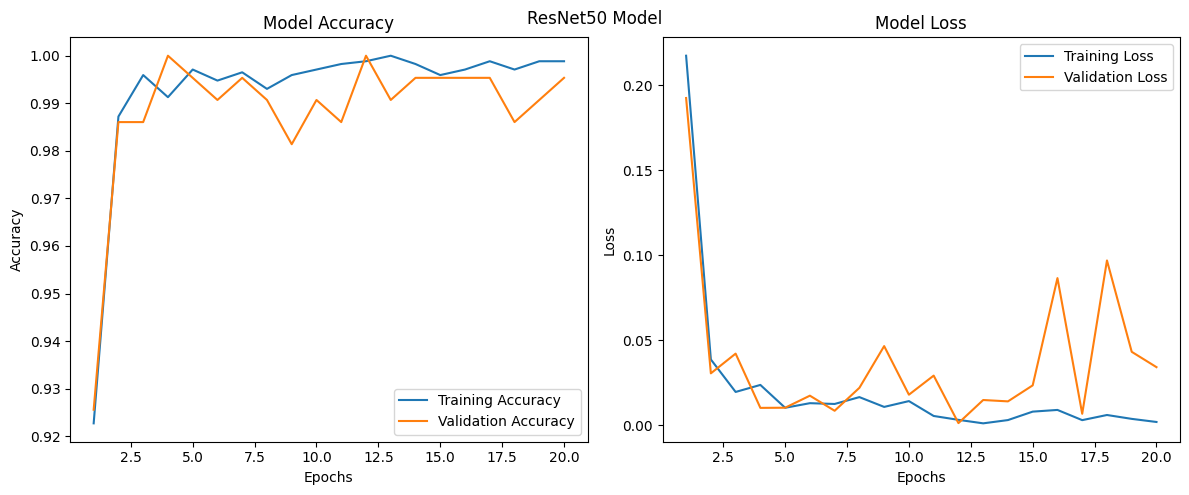

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, resnet50_with_aug_acc, label='Training Accuracy')
plt.plot(n, resnet50_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, resnet50_with_aug_loss, label='Training Loss')
plt.plot(n, resnet50_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('ResNet50 Model')
plt.savefig("plot_resnet50.png")
plt.show()

### Prediction of images using ResNet50

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


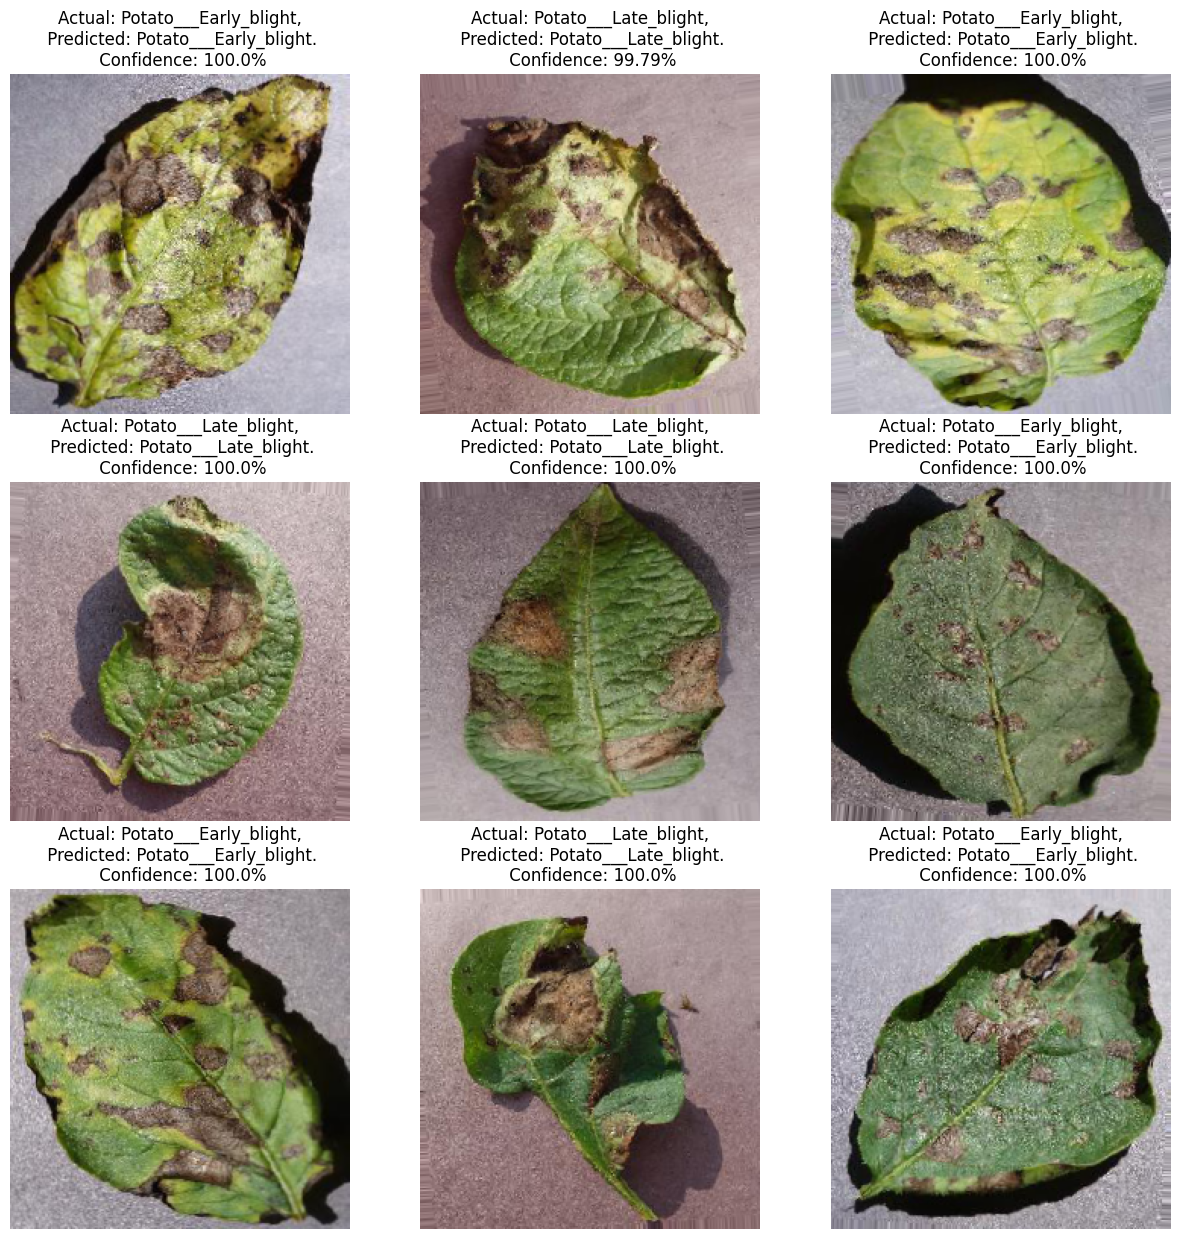

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(resnet50_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("ResNet50V2_prediction images")

### Compare the transfer learning models performances

#### Comparing the test accuracies

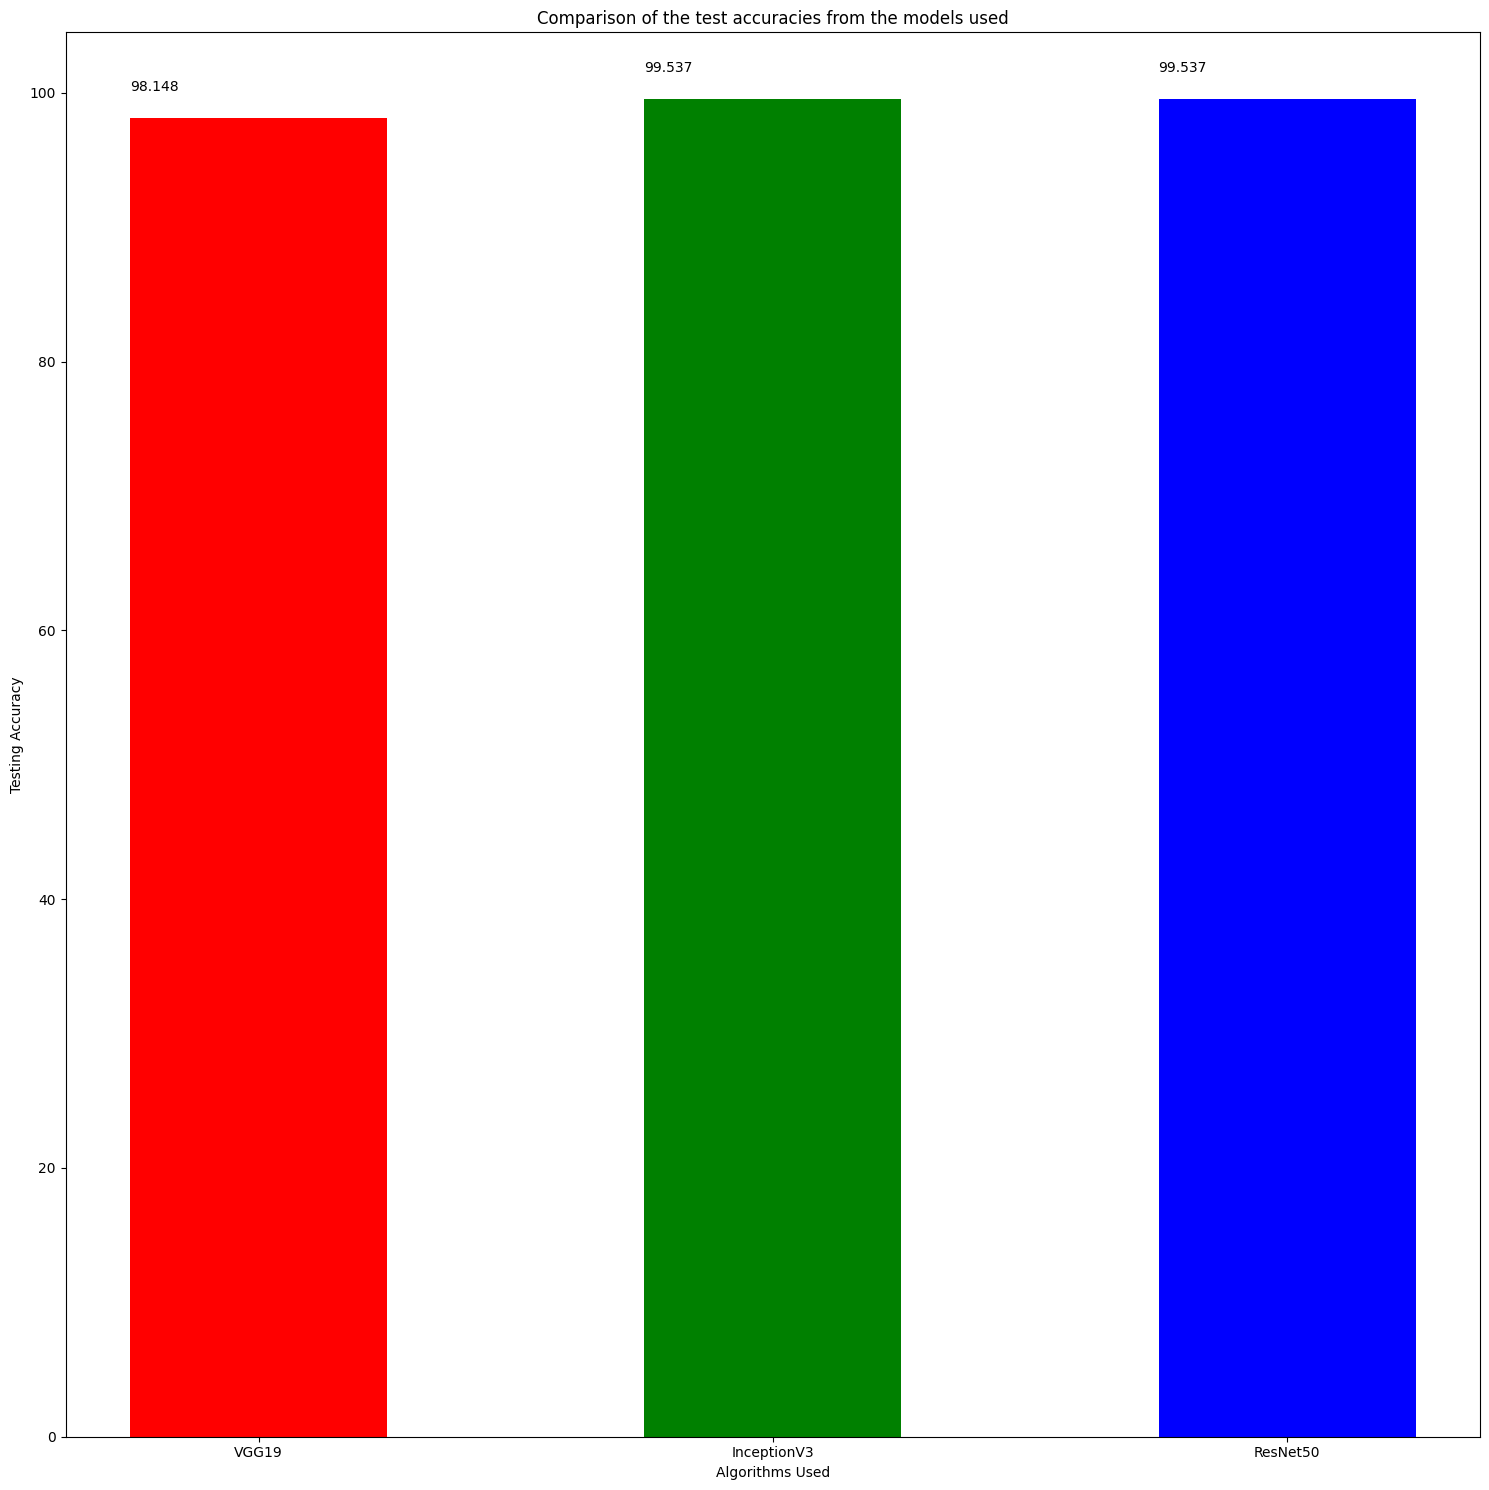

In [ ]:
algorithms = ['VGG19', 'InceptionV3', 'ResNet50']
accuracy = [vgg19_with_aug_test_acc, inceptionv3_with_aug_test_acc, resnet50_with_aug_test_acc]
accuracy = np.around([i for i in accuracy], 3)
colours = ['red', 'green', 'blue']

fig = plt.figure(figsize=(15,15))

# Plotting the bar chart
bars = plt.bar(algorithms, accuracy, color=colours, width = 0.5)

plt.xlabel("Algorithms Used")
plt.ylabel("Testing Accuracy")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+2, yval)
    
plt.title('Comparison of the test accuracies from the models used')
plt.tight_layout()
plt.savefig('comparison_of_test_accuracies.png')
plt.show()

#### Comparing the test loss

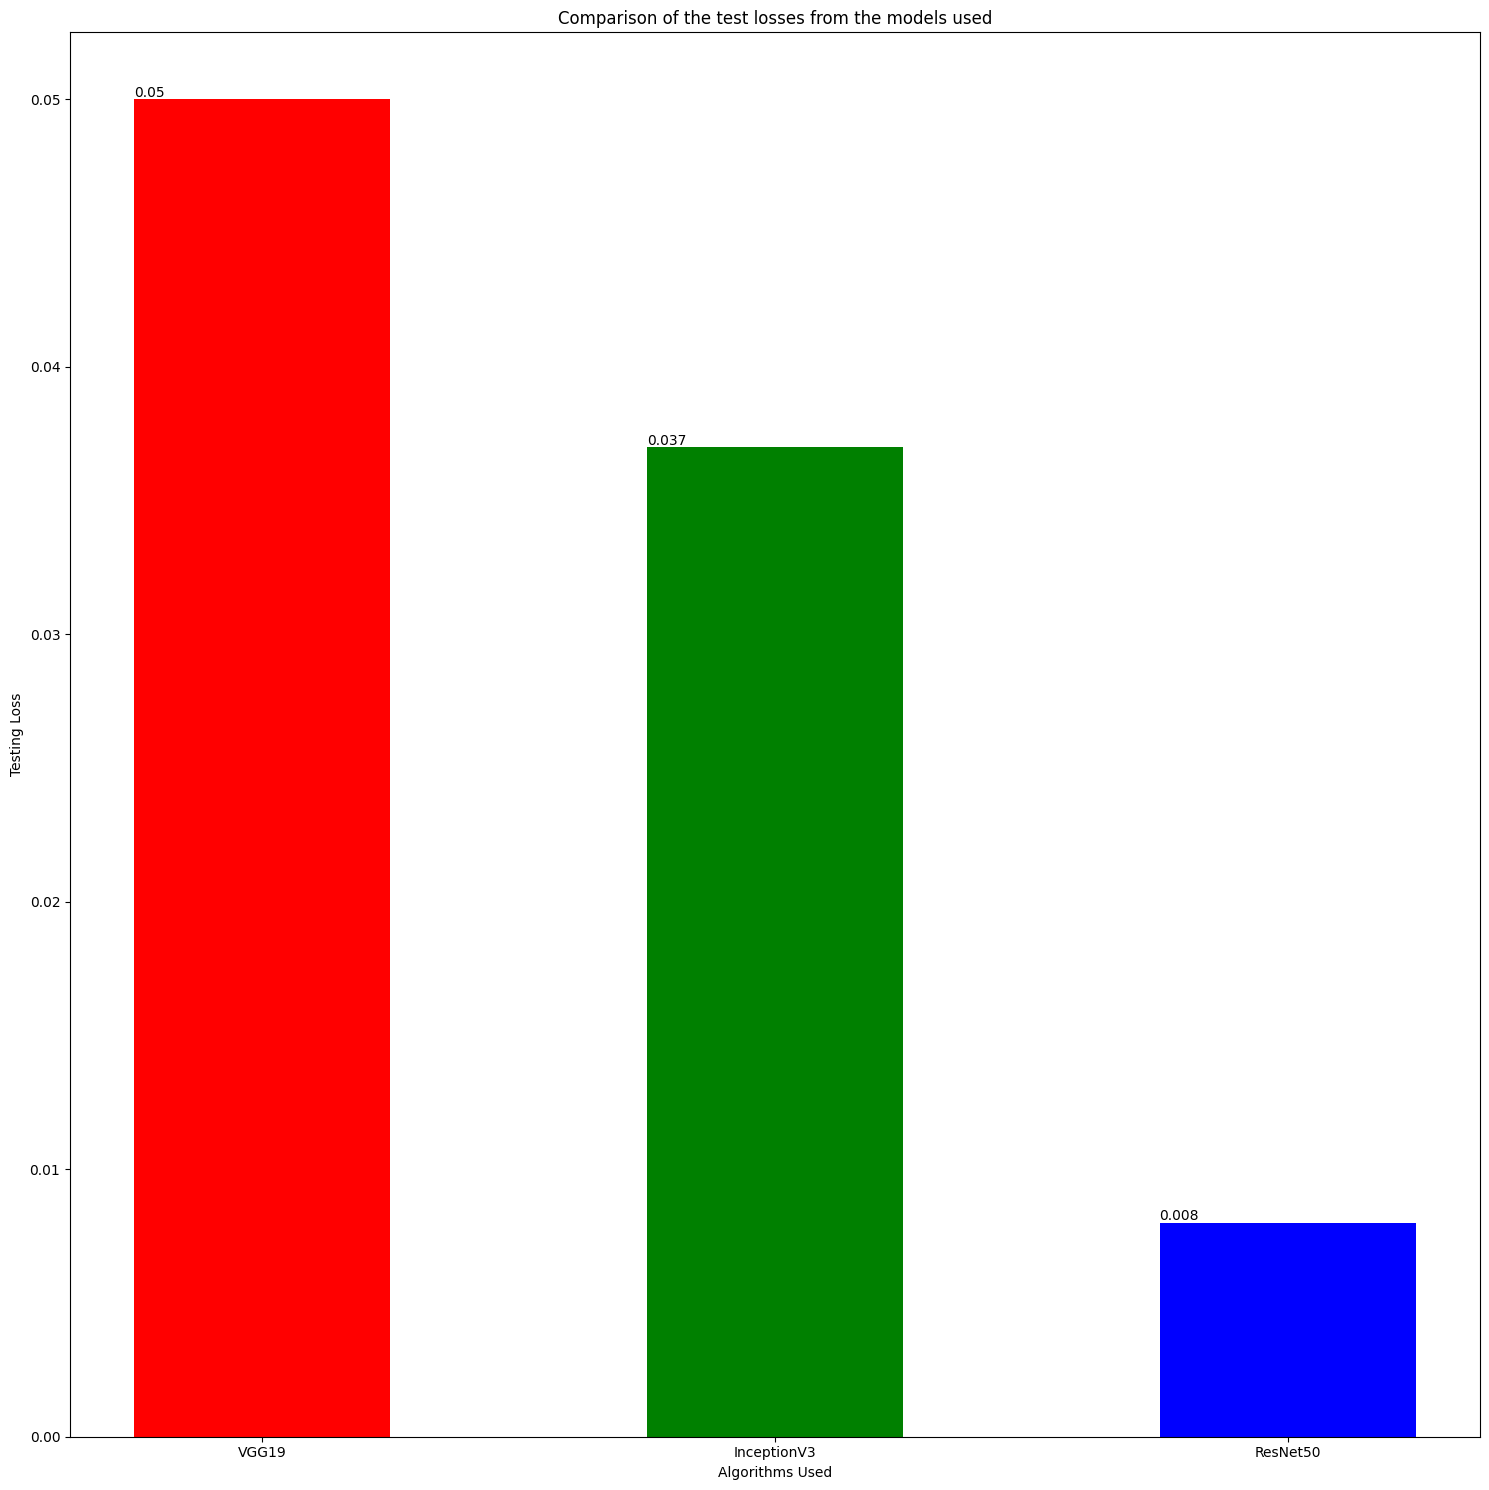

In [ ]:
algorithms = ['VGG19', 'InceptionV3', 'ResNet50']
loss = [vgg19_with_aug_test_loss, inceptionv3_with_aug_test_loss, resnet50_with_aug_test_loss]
loss = np.around([i for i in loss], 3)
colours = ['red', 'green', 'blue']

fig = plt.figure(figsize=(15,15))

# Plotting the bar chart
bars = plt.bar(algorithms, loss, color=colours, width = 0.5)

plt.xlabel("Algorithms Used")
plt.ylabel("Testing Loss")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+0.00009, yval)
    
plt.title('Comparison of the test losses from the models used')
plt.tight_layout()
plt.savefig('comparison_of_test_losses.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html PlantVillageTransferLearning.ipynb

[NbConvertApp] WARNING | pattern 'PlantVillageTransferLearning.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=Tr